In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
# Import libraries
import xarray as xr
import numpy as np
import os
import pandas as pd
import sys
sys.path.append("/Users/ccamargo/Documents/github/SLB/")

from utils_SLB import cluster_mean, plot_map_subplots, sum_linear, sum_square, get_dectime
from utils_SLB import plot_map2 as plot_map

sys.path.append("/Users/ccamargo/Documents/py_scripts/")
import utils_SL as sl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cm
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
cmap_trend = cm.cm.balance
cmap_unc = cm.tools.crop(cmap_trend,0,3,0)

In [15]:
import seaborn as sns
import scipy.stats as st
# from scipy import stats
# from sklearn import linear_model
#import statsmodels.api as sm
#from statsmodels.multivariate.manova import MANOVA
import sklearn.metrics as metrics
import random

In [3]:
import warnings
warnings.filterwarnings("ignore","Mean of empty slice", RuntimeWarning)

In [4]:
def compare_values(x,x_unc,y,y_unc):
    # is y within the interval of x:
    if x+x_unc>= y and x-x_unc<=y:
        #print('y within x')
        agree = 1
    elif y+y_unc>= x and y-y_unc<=x:
        #print('x within y')
        agree = 1
    else: 
        agree=0
    return agree

## Get data

In [5]:
#%% get budget components
path = '/Volumes/LaCie_NIOZ/data/budget/'
dic = pd.read_pickle(path+'budget_v2.pkl')


In [6]:
# dimensions
period = ['1993-2017'] # full years
y0,y1=period[0].split('-')
t0='{}-01-01'.format(int(y0))
t1='{}-12-31'.format(int(y1)-1)
path = '/Volumes/LaCie_NIOZ/data/budget/ts/' 
ds = xr.open_dataset(path+'alt.nc')
ds = ds.sel(time=slice(t0,t1))
lat=np.array(ds.lat)
lon=np.array(ds.lon)

tdec = get_dectime(ds.time)
da = ds['sla_ens'][0,:,:]
da = da.where((ds.lat>-66) & (ds.lat<66),np.nan)
# da.plot()
landmask = np.array(da.data)
landmask[np.isfinite(landmask)]=1
# plt.pcolor(landmask)


# Figure 3 - Clusters Residuals

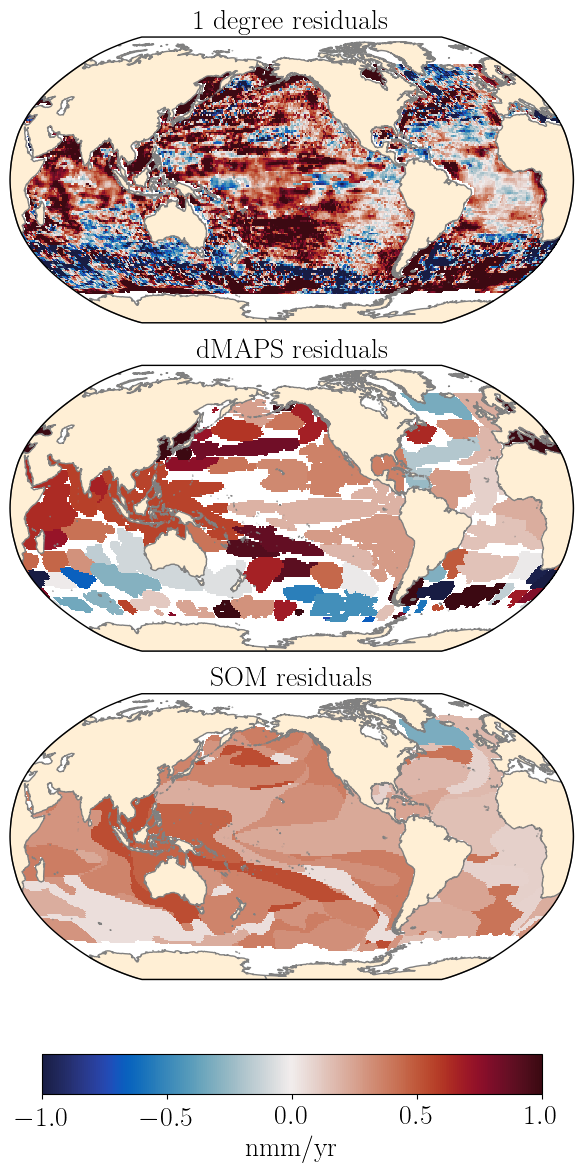

In [7]:
#%% Plot residual clusters
#% % make list with datasets
das_res = [dic['res']['trend'],
           dic['dmap']['res']['trend'],
           dic['som']['res']['trend'],
                ]

titles = ["1 degree residuals",
            r"dMAPS residuals ", 
          r"SOM residuals ",
          # r"unc", r"unc",                     
          ]

#% % plot trends for each component
clim=1
plot_map_subplots( das_res,
             plot_type = 'pcolor',
             lon=lon,lat=lat,
             cmap=cmap_trend,
             cmin=-clim,cmax=clim,
             titles=titles,
             clabel='nmm/yr',
             lon0=210, offset_y = -0.2,
             fontsize=25,
             fsize=(10,10),
             nrow=3,ncol=1
             )


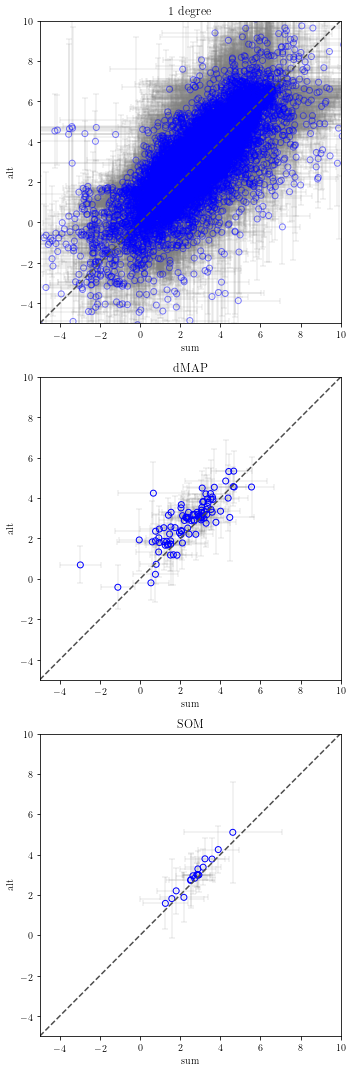

In [8]:
#%% scatter trend
plt.figure(figsize=(5,15))
nrow=3
ncol=1

key ='som' # cluster
mask = np.array(dic[key]['mask']) # clusters mask
mask_tmp = np.array(mask)
mask_tmp[np.isfinite(mask_tmp)]=1

plt.subplot(nrow,ncol,1)
plt.title('1 degree')
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]



plt.xlim([-5,10])
plt.ylim([-5,10])
plt.plot([-5, 10], [-5, 10], ls="--", c=".3")

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            alpha=0.5,
            marker='o',facecolors='none', edgecolors='b'
           )

plt.xlabel('sum')
plt.ylabel('alt')


########################
plt.subplot(nrow,ncol,3)
plt.title('SOM')
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            marker='o',facecolors='none', edgecolors='b'
           )
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])

plt.xlim([-5,10])
plt.ylim([-5,10])
plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.xlabel('sum')
plt.ylabel('alt')


###############################
ax = plt.subplot(nrow,ncol,2)
plt.title('dMAP')
key='dmap'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            marker='o',facecolors='none', edgecolors='b'
           )

plt.xlim([-5,10])
plt.ylim([-5,10])
plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.xlabel('sum')
plt.ylabel('alt')

plt.tight_layout()
plt.show()

# Test histograms

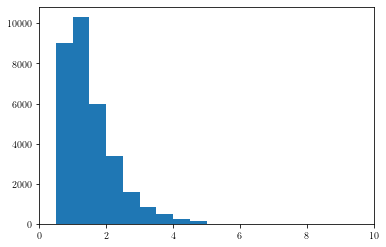

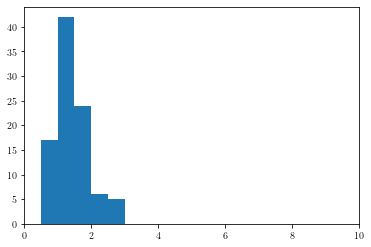

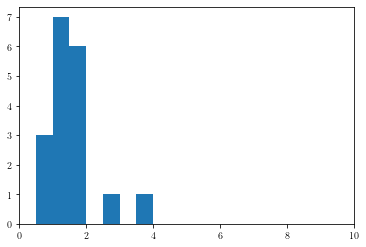

In [9]:
clim=5
das_res = [dic['res']['unc'],
           dic['dmap']['df']['res_unc'],
           dic['som']['df']['res_unc'],
                ]
for data in das_res:
    data = np.array(data).flatten()
    data = data[np.isfinite(data)]
    plt.figure()
    plt.hist(data, bins=np.arange(-clim, clim+0.1,0.5))
    plt.xlim(0,10)
    plt.show()

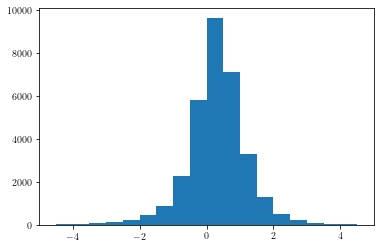

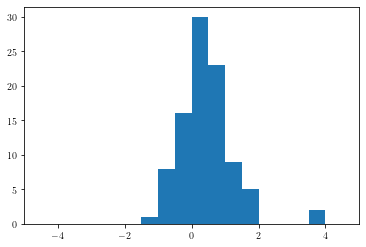

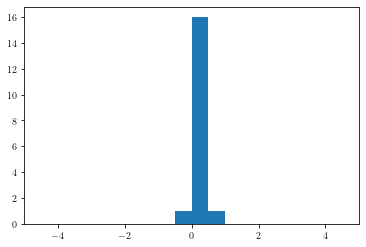

In [10]:
das_res = [dic['res']['trend'],
           dic['dmap']['df']['res_tr'],
           dic['som']['df']['res_tr'],
                ]
for data in das_res:
    data = np.array(data).flatten()
    data = data[np.isfinite(data)]
    plt.figure()
    plt.hist(data, bins=np.arange(-clim, clim+0.1,0.5))
    plt.xlim(-5,5)
    plt.show()

In [16]:
das_res = [dic['res']['trend'],
           dic['dmap']['df']['res_tr'],
           dic['som']['df']['res_tr'],
                ]
das_alt = [dic['alt']['trend'],
           dic['dmap']['df']['alt_tr'],
           dic['som']['df']['alt_tr'],
                ]
das_sum = [dic['sum']['trend'],
           dic['dmap']['df']['sum_tr'],
           dic['som']['df']['sum_tr'],
                ]

das_res_u = [dic['res']['unc'],
           dic['dmap']['df']['res_unc'],
           dic['som']['df']['res_unc'],
                ]

das_sum_u = [dic['sum']['unc'],
           dic['dmap']['df']['sum_unc'],
           dic['som']['df']['sum_unc'],
                ]

das_alt_u = [dic['alt']['unc'],
           dic['dmap']['df']['alt_unc'],
           dic['som']['df']['alt_unc'],
                ]

for i in range(3):
    df = pd.DataFrame({'alt':np.hstack(das_alt[i]),
                       'sum':np.hstack(das_sum[i]),
                      # 'res':np.hstack(das_res[i])
                      })

    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)

    plt.figure()
    sns.histplot(df,kde=False, #label='Trend',
                 alpha=0.5,
                 # stat="percent", 
                bins=np.arange(-clim, clim+0.1,0.5))

    df2 = pd.DataFrame({'alt':np.hstack(das_alt_u[i]),
                       'sum':np.hstack(das_sum_u[i]),
                      # 'res':np.hstack(das_res_u[i])
                      })
    df2.dropna(inplace=True)
    df2.reset_index(inplace=True)
    df2 = df2.drop('index',axis=1)
    var = 'sum'
    x = np.array(df2[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='orange',linestyle='-')

    plt.axvline(ci[0],c='orange',linestyle='--',alpha=1,label='{}% CI'.format(ci_level*100))
    plt.axvline(ci[1],c='orange',linestyle='--',alpha=0.5)

    ci_width = np.abs(ci[0]-ci[1])/2
    ws.append(ci_width)

    var = 'alt'
    x = np.array(df2[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='blue',linestyle='-')

    plt.axvline(ci[0],c='blue',linestyle='--',alpha=1,label='{}% CI'.format(ci_level*100))
    plt.axvline(ci[1],c='blue',linestyle='--',alpha=0.5)
    plt.show()


TypeError: bad operand type for unary -: 'list'

<Figure size 432x288 with 0 Axes>

In [ ]:
das_res = [dic['res']['trend'],
           dic['dmap']['df']['res_tr'],
           dic['som']['df']['res_tr'],
                ]
das_alt = [dic['alt']['trend'],
           dic['dmap']['df']['alt_tr'],
           dic['som']['df']['alt_tr'],
                ]
das_sum = [dic['sum']['trend'],
           dic['dmap']['df']['sum_tr'],
           dic['som']['df']['sum_tr'],
                ]

das_res_u = [dic['res']['unc'],
           dic['dmap']['df']['res_unc'],
           dic['som']['df']['res_unc'],
                ]

das_sum_u = [dic['sum']['unc'],
           dic['dmap']['df']['sum_unc'],
           dic['som']['df']['sum_unc'],
                ]

das_alt_u = [dic['alt']['unc'],
           dic['dmap']['df']['alt_unc'],
           dic['som']['df']['alt_unc'],
                ]

for i in range(3):
    df = pd.DataFrame({'alt':np.hstack(das_alt[i]),
                       'sum':np.hstack(das_sum[i]),
                      # 'res':np.hstack(das_res[i])
                      })

    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)

    plt.figure()
    sns.histplot(df,kde=False, #label='Trend',
                 alpha=0.5,
                 # stat="percent", 
                bins=np.arange(-clim, clim+0.1,0.5))

    df2 = pd.DataFrame({'alt':np.hstack(das_alt_u[i]),
                       'sum':np.hstack(das_sum_u[i]),
                      # 'res':np.hstack(das_res_u[i])
                      })
    df2.dropna(inplace=True)
    df2.reset_index(inplace=True)
    df2 = df2.drop('index',axis=1)
    var = 'sum'
    x = np.array(df2[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='orange',linestyle='-')


    ci_width = np.abs(ci[0]-ci[1])/2
    ws.append(ci_width)

    var = 'alt'
    x = np.array(df2[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='blue',linestyle='-')

    print(x.mean())
    plt.show()


In [ ]:
das_res = [dic['res']['trend'],
           dic['dmap']['df']['res_tr'],
           dic['som']['df']['res_tr'],
                ]
das_alt = [dic['alt']['trend'],
           dic['dmap']['df']['alt_tr'],
           dic['som']['df']['alt_tr'],
                ]
das_sum = [dic['sum']['trend'],
           dic['dmap']['df']['sum_tr'],
           dic['som']['df']['sum_tr'],
                ]

das_res_u = [dic['res']['unc'],
           dic['dmap']['df']['res_unc'],
           dic['som']['df']['res_unc'],
                ]

das_sum_u = [dic['sum']['unc'],
           dic['dmap']['df']['sum_unc'],
           dic['som']['df']['sum_unc'],
                ]

das_alt_u = [dic['alt']['unc'],
           dic['dmap']['df']['alt_unc'],
           dic['som']['df']['alt_unc'],
                ]
clim=7.5
title=['1 degree', 'dmap', 'som']
i=0
for trend,unc in zip(das_res,das_res_u):
    df= pd.DataFrame( {
                    'Trend':np.hstack(trend),
    'Unc':np.hstack(unc),
    })
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)
    
    plt.figure()
    sns.histplot(df,kde=False, #label='Trend',
                 alpha=0.5,
                 # stat="percent", 
                bins=np.arange(-clim, clim+0.1,0.5))

    # plt.legend(prop={'size': 12})
    plt.xlabel('mm/yr')
    plt.ylabel('Number regions')
    plt.title(title[i])
    i=i+1
    plt.xlim(-clim,clim)
    plt.show()

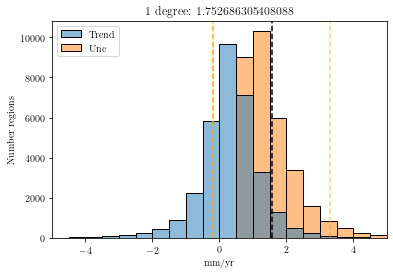

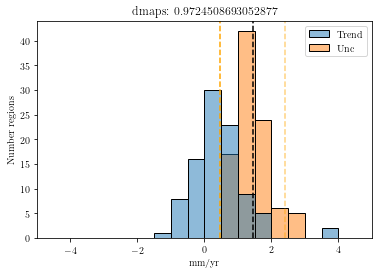

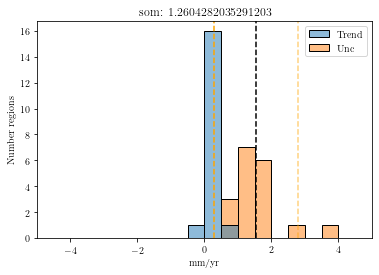

In [13]:
i=0
ws = []
title=['1 degree', ' dmaps', 'som']
for trend,unc in zip(das_res,das_res_u):
    df= pd.DataFrame( {
                    'Trend':np.hstack(trend),
    'Unc':np.hstack(unc),
    })
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)
    
    plt.figure()
    sns.histplot(df,kde=False, #label='Trend',
                 alpha=0.5,
                 # stat="percent", 
                bins=np.arange(-clim, clim+0.1,0.5))

    # plt.legend(prop={'size': 12})
    plt.xlabel('mm/yr')
    plt.ylabel('Number regions')
   
    plt.xlim(-clim,clim)
    

    var = 'Unc'
    x = np.array(df[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='k',linestyle='--')

    plt.axvline(ci[0],c='orange',linestyle='--',alpha=1,label='{}% CI'.format(ci_level*100))
    plt.axvline(ci[1],c='orange',linestyle='--',alpha=0.5)
    
    ci_width = np.abs(ci[0]-ci[1])/2
    ws.append(ci_width)
    plt.title(title[i]+': {}'.format( ci_width))
    plt.show()
    i=i+1
    

NameError: name 'r2_score' is not defined

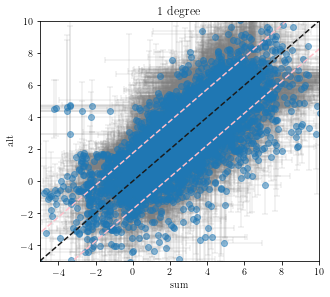

In [17]:
plt.figure(figsize=(5,15))
nrow=3
ncol=1

key ='som' # cluster
mask = np.array(dic[key]['mask']) # clusters mask
mask_tmp = np.array(mask)
mask_tmp[np.isfinite(mask_tmp)]=1

ax=plt.subplot(nrow,ncol,1)
plt.title('1 degree')
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]



cmin=-5
cmax=10
clim = [cmin,cmax]
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[0]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c="pink")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c="pink")

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            alpha=0.5,
            marker='o',
            # facecolors='none', edgecolors='b'
           )

plt.xlabel('sum')
plt.ylabel('alt')

plt.xlim(clim)
plt.ylim(clim)
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))


########################
ax=plt.subplot(nrow,ncol,3)
plt.title('SOM')
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
           # marker='o',facecolors='none', edgecolors='b'
           )
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])

clim = [cmin,cmax]
plt.xlim(clim)
plt.ylim(clim)
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[2]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c="pink")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c="pink")
plt.xlabel('sum')
plt.ylabel('alt')
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))

###############################
ax = plt.subplot(nrow,ncol,2)
plt.title('dMAP')
key='dmap'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
           # marker='o',facecolors='none', edgecolors='b'
           )

clim = [cmin,cmax]
plt.xlim(clim)
plt.ylim(clim)
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[1]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c="pink")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c="pink")

plt.xlabel('sum')
plt.ylabel('alt')
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))
plt.tight_layout()
plt.show()

Caption: R-squared measured between (alt, sum of components). Black dashed line inidicates 1:1 correlation, and pink dashed lines the half-width of the 95% confidence interval of the uncertainty distribution (residuals)

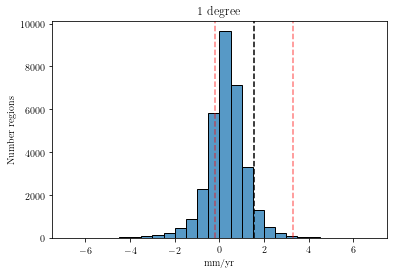

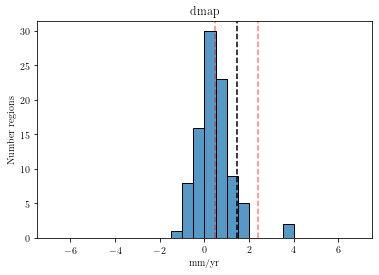

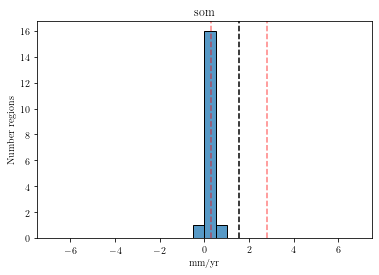

In [38]:
i=0
clim = 7.5
for trend,unc in zip(das_res,das_res_u):
    df= pd.DataFrame( {
                    'Trend':np.hstack(trend),
    'Unc':np.hstack(unc),
    })
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)
    
    plt.figure()
    sns.histplot(df['Trend'],
                 kde=False, #label='Trend',
                bins=np.arange(-clim, clim+0.1,0.5))

    # plt.legend(prop={'size': 12})
    plt.xlabel('mm/yr')
    plt.ylabel('Number regions')
    plt.title(title[i])
    i=i+1
    plt.xlim(-clim,clim)
    
    var = 'Unc'
    x = np.array(df[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='k',linestyle='--')

    plt.axvline(ci[0],c='red',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
    plt.axvline(ci[1],c='red',linestyle='--',alpha=0.5)
    plt.show()

In [39]:
x = np.array(df['Trend'])
ci = st.norm.interval(alpha=0.95, loc=np.mean(x), scale=x.std())
ci

(-0.1320854332165745, 0.5885750392870603)

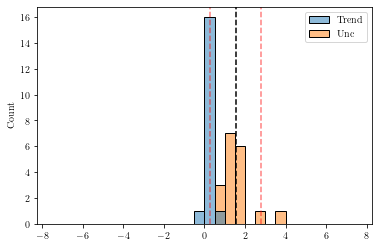

In [41]:
plt.figure()

sns.histplot(df,kde=False, #label='Trend',
            bins=np.arange(-clim, clim+0.1,0.5))
var = 'Unc'
x = np.array(df[var])
ci_level=0.95
ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
plt.axvline(x.mean(),color='k',linestyle='--')

plt.axvline(ci[0],c='red',linestyle='--',alpha=0.5,label='{}% CI'.format(ci_level*100))
plt.axvline(ci[1],c='red',linestyle='--',alpha=0.5)


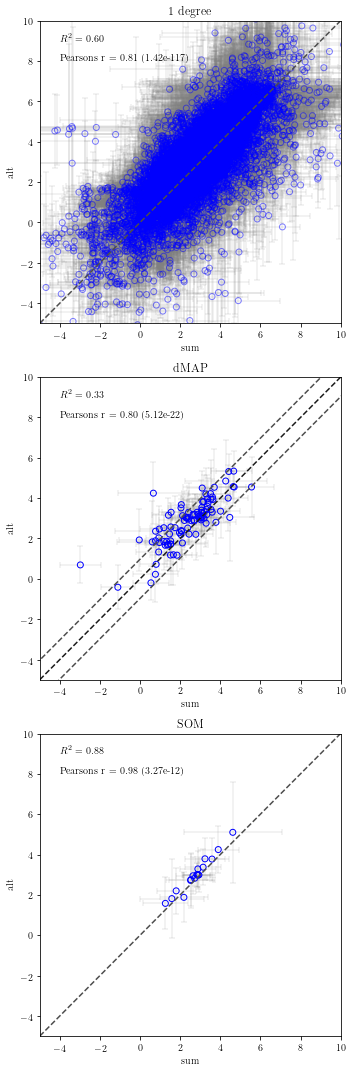

In [167]:
#%% scatter trend
plt.figure(figsize=(5,15))
nrow=3
ncol=1

key ='som' # cluster
mask = np.array(dic[key]['mask']) # clusters mask
mask_tmp = np.array(mask)
mask_tmp[np.isfinite(mask_tmp)]=1

ax = plt.subplot(nrow,ncol,1)
plt.title('1 degree')
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]



plt.xlim([-5,10])
plt.ylim([-5,10])
plt.plot([-5, 10], [-5, 10], ls="--", c=".3")

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            alpha=0.5,
            marker='o',facecolors='none', edgecolors='b'
           )

plt.xlabel('sum')
plt.ylabel('alt')
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))



########################
ax=plt.subplot(nrow,ncol,3)
plt.title('SOM')
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            marker='o',facecolors='none', edgecolors='b'
           )
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])

plt.xlim([-5,10])
plt.ylim([-5,10])
plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.xlabel('sum')
plt.ylabel('alt')

if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))


###############################
ax = plt.subplot(nrow,ncol,2)
plt.title('dMAP')
key='dmap'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            marker='o',facecolors='none', edgecolors='b'
           )


plt.xlabel('sum')
plt.ylabel('alt')
clim = [cmin,cmax]
plt.xlim(clim)
plt.ylim(clim)
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[1]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c=".3")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c=".3")

if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.2f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))


plt.tight_layout()
plt.show()

caption: R2(altimetry,sum)

In [166]:
print("Pearsons r = {:.2f} ({:.2e})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]))

Pearsons r = 0.799 (5.12e-22)


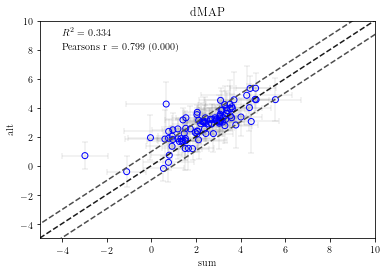

In [159]:
plt.figure()
###############################
ax = plt.subplot(111)
plt.title('dMAP')
key='dmap'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            marker='o',facecolors='none', edgecolors='b'
           )


plt.xlabel('sum')
plt.ylabel('alt')
clim = [cmin,cmax]
plt.xlim(clim)
plt.ylim(clim)
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[1]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c=".3")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c=".3")

if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.3f}".format(r2_score(y,x)), (clim[0]+1,clim[1]-1))
ax.annotate("Pearsons r = {:.3f} ({:.3f})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (clim[0]+1,clim[1]-2))

plt.show()

In [148]:
clim[0]

-5

In [149]:
clim[1]

10

In [82]:
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]



In [83]:
metrics.explained_variance_score(x,y) # ‘explained_variance’

0.9429032672539952

In [84]:
metrics.max_error(x,y) # max error

0.5514389216994204

In [85]:
metrics.mean_absolute_error(x,y) # ‘neg_mean_absolute_error’

0.26340760787722856

In [86]:
metrics.mean_squared_error (x,y)# ‘neg_mean_squared_error’

0.08709803056377007

In [87]:
metrics.median_absolute_error(x,y) # ‘neg_median_absolute_error’

0.23000246887995524

In [92]:
metrics.r2_score(x,y) # r2

0.8561733404769685

In [89]:
metrics.mean_absolute_percentage_error(x,y)

0.10387031606061253

In [138]:
len(x)

500

(0.8450849308232523, 1.5749139756196608e-137)


(-7.5, 7.5)

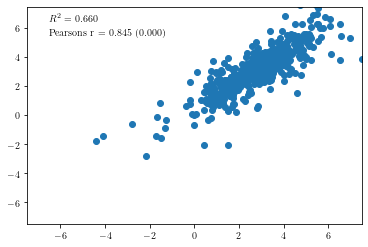

In [140]:
plt.figure()
ax=plt.subplot()
plt.scatter(x,y)
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
ax.annotate("$R^2$ = {:.3f}".format(r2_score(y,x)), (-clim+1, clim-1))
ax.annotate("Pearsons r = {:.3f} ({:.3f})".format(
    stats.pearsonr(xx, yy)[0], stats.pearsonr(xx, yy)[1]), (-clim+1, clim-2))
print(stats.pearsonr(x, y))
plt.xlim([-clim,clim])
plt.ylim([-clim,clim])

In [134]:
print(stats.pearsonr(x, y))

(0.8450849308232523, 1.5749139756196608e-137)


AttributeError: 'NoneType' object has no attribute 'pvalue'

(-7.5, 7.5)

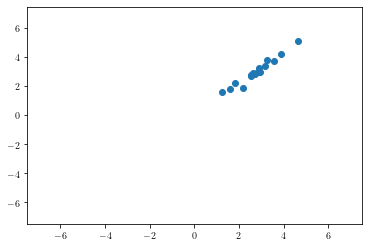

In [96]:
plt.scatter(x,y)
ax.annotate("r-squared = {:.3f}".format(r2_score(x,y)), (-clim+1, clim-1))
plt.xlim([-clim,clim])
plt.ylim([-clim,clim])

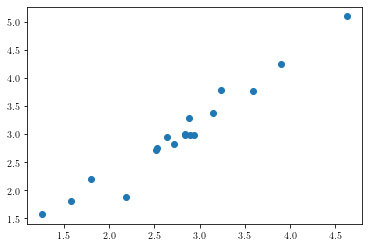


Test of normality:
x
ShapiroResult(statistic=0.9638174176216125, pvalue=0.6766440272331238)
y
ShapiroResult(statistic=0.9508694410324097, pvalue=0.43881887197494507)

t-test
Ttest_relResult(statistic=-5.081633294910923, pvalue=9.240598303148813e-05)

Wilcoxon
WilcoxonResult(statistic=11.0, pvalue=0.00041961669921875)

Kruskal
KruskalResult(statistic=1.1571571571571582, pvalue=0.2820559021805429)

Pearsons
(0.9773290133837803, 3.268336634030448e-12)

r2 score
0.8561733404769685


In [109]:
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.scatter(x,y)
plt.show()

print('\nTest of normality:')
print('x')
print(stats.shapiro(x))
print('y')
print(stats.shapiro(y))

print('\nt-test')
print(stats.ttest_rel(x,y))

print('\nWilcoxon')
print(stats.wilcoxon(x,y))


print('\nKruskal')
print(stats.kruskal(x, y))


print('\nPearsons')
print(stats.pearsonr(x, y))

print('\nr2 score')
print(metrics.r2_score(x,y))

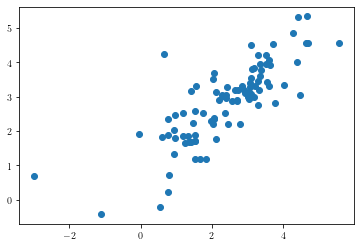


Test of normality:
x
ShapiroResult(statistic=0.9620121717453003, pvalue=0.007905160076916218)
y
ShapiroResult(statistic=0.9800522327423096, pvalue=0.16129399836063385)

t-test
Ttest_relResult(statistic=-5.461290435962402, pvalue=3.9185828719284123e-07)

Wilcoxon
WilcoxonResult(statistic=835.0, pvalue=1.365122557898793e-07)

Kruskal
KruskalResult(statistic=5.833286626858353, pvalue=0.015725717241029818)

Pearsons
(0.7988087641224608, 5.118783417928933e-22)

r2 score
0.518572409877208


In [110]:
key='dmap'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.scatter(x,y)
plt.show()

print('\nTest of normality:')
print('x')
print(stats.shapiro(x))
print('y')
print(stats.shapiro(y))

print('\nt-test')
print(stats.ttest_rel(x,y))

print('\nWilcoxon')
print(stats.wilcoxon(x,y))

print('\nKruskal')
print(stats.kruskal(x, y))


print('\nPearsons')
print(stats.pearsonr(x, y))

print('\nr2 score')
print(metrics.r2_score(x,y))

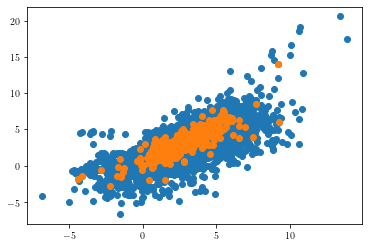


Test of normality:
x
ShapiroResult(statistic=0.9765552878379822, pvalue=3.446818368502136e-07)
y
ShapiroResult(statistic=0.9663736820220947, pvalue=2.7496358523393383e-09)

t-test
Ttest_relResult(statistic=-7.700898656821022, pvalue=7.318501438523015e-14)

Wilcoxon
WilcoxonResult(statistic=34400.0, pvalue=2.4998851093426974e-18)

Kruskal
KruskalResult(statistic=9.819433366632893, pvalue=0.0017267753316707682)

Pearsons
(0.8450849308232523, 1.5749139756196608e-137)

r2 score
0.6455378708675976


In [131]:
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.scatter(x,y)

if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    x=x[idx]
    y = y[idx]
#    y = random.sample(list(y),500)
plt.scatter(x,y)
plt.show()
print('\nTest of normality:')
print('x')
print(stats.shapiro(x))
print('y')
print(stats.shapiro(y))

print('\nt-test')
print(stats.ttest_rel(x,y))

print('\nWilcoxon')
print(stats.wilcoxon(x,y))

print('\nKruskal')
print(stats.kruskal(x, y))

print('\nPearsons')
print(stats.pearsonr(x, y))

print('\nr2 score')
print(metrics.r2_score(x,y))

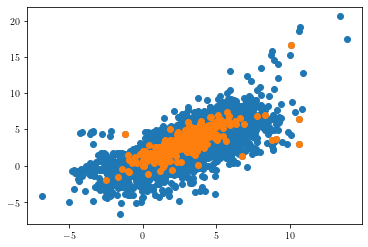

In [130]:
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.scatter(x,y)


if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    x=x[idx]
    y = y[idx]
#    y = random.sample(list(y),500)
plt.scatter(x,y)

In [126]:
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

x

array([0.94979986, 0.91897936, 0.79164729, ..., 2.46759489, 2.77147246,
       3.0835928 ])

In [108]:
stats.pearsonr(x, y)

(0.9773290133837803, 3.268336634030448e-12)

In [128]:
list(x).index()

TypeError: index() takes at least 1 argument (0 given)

In [194]:
df = dic['som']['df']
df2 = pd.DataFrame({'alt':df['alt_tr'],
                   'sdsl':df['steric_tr']+df['dynamic_tr'],
                   'bar':df['barystatic_tr']})

fit = MANOVA.from_formula('sdsl + bar ~ alt', data=df2)
print(fit.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
        Intercept         Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda  0.0856 2.0000 15.0000 80.0821 0.0000
          Pillai's trace  0.9144 2.0000 15.0000 80.0821 0.0000
  Hotelling-Lawley trace 10.6776 2.0000 15.0000 80.0821 0.0000
     Roy's greatest root 10.6776 2.0000 15.0000 80.0821 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          alt            Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0334 2.0000 15.0000 217.0346 0.0000
         Pillai's trace  0.9666 2.0000 15.0000 217.0346 0.0000
 Hotelling-

In [206]:
df = dic['dmap']['df']
df.dropna(inplace=True)
df.reset_index(inplace=True)
df = df.drop('index',axis=1)

df2 = pd.DataFrame({'alt':df['alt_tr'],
                   'ssl':df['steric_tr'],
                    'dsl':df['dynamic_tr'],
                   'bar':df['barystatic_tr']})

X = df2[['ssl','dsl','bar']]
Y = df2['alt']


model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                    alt   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              690.0
Date:                Mon, 11 Apr 2022   Prob (F-statistic):                    1.93e-62
Time:                        18:02:18   Log-Likelihood:                         -89.572
No. Observations:                  94   AIC:                                      185.1
Df Residuals:                      91   BIC:                                      192.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [231]:
print('1 Degree')
df = pd.DataFrame(
    {'alt_tr':np.hstack(dic['alt']['trend']),
     'steric_tr':np.hstack(dic['steric']['trend']),
     'barystatic_tr':np.hstack(dic['barystatic']['trend']),
     'dynamic_tr':np.hstack(dic['dynamic']['trend']),
     'sum_tr':np.hstack(dic['sum']['trend'])
     
    })
    
df.dropna(inplace=True)
df.reset_index(inplace=True)
df = df.drop('index',axis=1)

print('Pearsons coef: ')
print('r (alt,sum): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[1],
))
print('r (alt,ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[1],
))
print('r (alt,dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[1],
))
print('r (alt,bsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[1],
))

print('r (alt,bsl+ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[1],
))

print('r (alt,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))

print('r (sum,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))


print('--')
print('r2 (alt,sum): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['sum_tr'])))
print('r2 (alt,ssl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr'])))
print('r2 (alt,dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['dynamic_tr'])))
print('r2 (alt,ssl+dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr']+df['dynamic_tr'])))
print('r2 (alt,bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['barystatic_tr'])))

print('r2 (sum,ssl+dsl+bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],
                                                             df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])))


1 Degree
Pearsons coef: 
r (alt,sum): 0.759 (0.00e+00)
r (alt,ssl): 0.714 (0.00e+00)
r (alt,dsl): 0.138 (9.69e-138)
r (alt,bsl): 0.087 (2.33e-55)
r (alt,bsl+ssl): 0.723 (0.00e+00)
r (alt,bsl+ssl+dsl): 0.759 (0.00e+00)
r (sum,bsl+ssl+dsl): 1.000 (0.00e+00)
--
r2 (alt,sum): 0.456
r2 (alt,ssl): -0.552
r2 (alt,dsl): -4.186
r2 (alt,ssl+dsl): -0.520
r2 (alt,bsl): -1.433
r2 (sum,ssl+dsl+bsl): 0.456


In [237]:
print('Dmaps')
df = dic['dmap']['df']
df.dropna(inplace=True)
# df.reset_index(inplace=True)
df = df.drop('index',axis=1)

print('Pearsons coef: ')
print('r (alt,sum): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[1],
))
print('r (alt,ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[1],
))
print('r (alt,dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[1],
))
print('r (alt,bsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[1],
))

print('r (alt,bsl+ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[1],
))

print('r (alt,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))

print('r (sum,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))


print('--')
print('r2 (alt,sum): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['sum_tr'])))
print('r2 (alt,ssl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr'])))
print('r2 (alt,dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['dynamic_tr'])))
print('r2 (alt,ssl+dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr']+df['dynamic_tr'])))
print('r2 (alt,bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['barystatic_tr'])))

print('r2 (sum,ssl+dsl+bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],
                                                             df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])))


Dmaps
Pearsons coef: 
r (alt,sum): 0.799 (5.12e-22)
r (alt,ssl): 0.766 (2.54e-19)
r (alt,dsl): 0.221 (3.26e-02)
r (alt,bsl): 0.239 (2.04e-02)
r (alt,bsl+ssl): 0.783 (1.24e-20)
r (alt,bsl+ssl+dsl): 0.818 (7.42e-24)
r (sum,bsl+ssl+dsl): 0.993 (4.77e-87)
--
r2 (alt,sum): 0.334
r2 (alt,ssl): -1.638
r2 (alt,dsl): -6.415
r2 (alt,ssl+dsl): -1.506
r2 (alt,bsl): -2.258
r2 (sum,ssl+dsl+bsl): 0.392


In [238]:
print('SOM')
df = dic['som']['df']
df.dropna(inplace=True)
# df.reset_index(inplace=True)
df = df.drop('index',axis=1)

print('Pearsons coef: ')
print('r (alt,sum): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['sum_tr'])[1],
))
print('r (alt,ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['steric_tr'])[1],
))
print('r (alt,dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['dynamic_tr'])[1],
))
print('r (alt,bsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr'])[1],
))

print('r (alt,bsl+ssl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr'])[1],
))

print('r (alt,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['alt_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))

print('r (sum,bsl+ssl+dsl): {:.3f} ({:.2e})'.format(
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[0], 
    stats.pearsonr(df['sum_tr'],df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])[1],
))


print('--')
print('r2 (alt,sum): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['sum_tr'])))
print('r2 (alt,ssl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr'])))
print('r2 (alt,dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['dynamic_tr'])))
print('r2 (alt,ssl+dsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['steric_tr']+df['dynamic_tr'])))
print('r2 (alt,bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],df['barystatic_tr'])))

print('r2 (sum,ssl+dsl+bsl): {:.3f}'.format(metrics.r2_score(df['alt_tr'],
                                                             df['barystatic_tr']+df['steric_tr']+df['dynamic_tr'])))


SOM
Pearsons coef: 
r (alt,sum): 0.977 (3.27e-12)
r (alt,ssl): 0.907 (2.14e-07)
r (alt,dsl): 0.035 (8.90e-01)
r (alt,bsl): 0.272 (2.75e-01)
r (alt,bsl+ssl): 0.920 (6.56e-08)
r (alt,bsl+ssl+dsl): 0.979 (1.59e-12)
r (sum,bsl+ssl+dsl): 1.000 (1.10e-25)
--
r2 (alt,sum): 0.879
r2 (alt,ssl): -2.574
r2 (alt,dsl): -11.477
r2 (alt,ssl+dsl): -1.809
r2 (alt,bsl): -4.658
r2 (sum,ssl+dsl+bsl): 0.887


In [ ]:


Stock_Market = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
                'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]        
                }

df = pd.DataFrame(Stock_Market,columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price'])

X = df[['Interest_Rate','Unemployment_Rate']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['Stock_Index_Price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
New_Interest_Rate = 2.75
New_Unemployment_Rate = 5.3
print ('Predicted Stock Index Price: \n', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)